In [1]:
device = 'cuda:0'

In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = MNIST(root='./mnist',train=True, download=True, transform=transform)
dataloader = DataLoader(train_dataset, batch_size=32)

validation_dataset = MNIST(root='./mnist', train=False, download=True, transform=transform)
dataloader_val = DataLoader(validation_dataset, batch_size=32)


In [3]:
import timm

model = timm.create_model('resnet18.a1_in1k', pretrained=False)

In [ ]:
import torch
import wandb
from torch import nn, optim

epochs = 10

with wandb.init(project="MNIST", name="training", config={"epochs": 50}) as run:
  calculate_loss = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  model = model.to(device)

  run.watch(model, log_freq=100)

  for epoch in range(epochs):
    model.train()
    print(f'Starting epoch {epoch}')

    run.log({
      "epoch": epoch,
    })

    
    train_avg_loss = 0.0

    for [idx, batch] in enumerate(dataloader):
      data, labels = batch
      
      data = data.to(device)
      labels = labels.to(device)
      
      optimizer.zero_grad()
      
      output = model(data)
      
      loss = calculate_loss(output, labels)
      train_avg_loss += loss.item()

      # Optional: Log batch loss periodically
      if idx % 50 == 0:  # Every 50 batches
        run.log({
          "batch_loss": loss.item(),
          "batch": epoch * len(dataloader) + idx
        })

      loss.backward()
      
      optimizer.step()


    train_avg_loss = train_avg_loss / len(dataloader)
    
    # Validation

    val_avg_loss = 0.0
    model.eval()

    with torch.no_grad():
      for [idx, batch] in enumerate(dataloader_val):
        data, labels = batch
        
        data = data.to(device)
        labels = labels.to(device)
        
        output = model(data)
        
        loss = calculate_loss(output, labels)
        val_avg_loss += loss.item()

        # del data
        # del labels
        # torch.cuda.empty_cache()


    val_avg_loss = val_avg_loss / len(dataloader_val)

    run.log({
      "train/loss": train_avg_loss,
      "val/loss": val_avg_loss,
      "epoch": epoch,
    })

  torch.save(model.state_dict(), f'model-epoch-{epoch}.pth')


wandb: Currently logged in as: mikmuellerdev (mikmuellerdev-university-of-potsdam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting epoch 0
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9


batch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
batch_loss,█▅▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train/loss,█▂▂▂▁▁▁▁▁▁
val/loss,█▂▂▁▂▁▁▁▂▁
batch,18725
batch_loss,0.0
epoch,9
train/loss,0.00984
val/loss,0.02383


In [5]:
torch.save(model.state_dict(), 'model.pth')

predicted: 1 | actual = 1


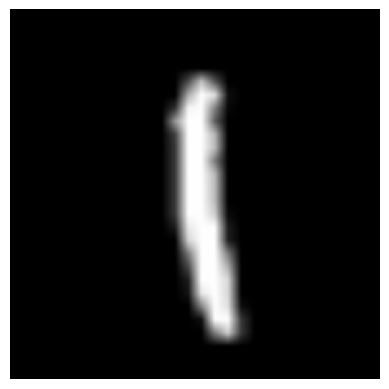

In [42]:
import random
import matplotlib.pyplot as plt

loaded_model = timm.create_model('resnet18.a1_in1k', pretrained=False)

weights = torch.load('model.pth', map_location=device)
loaded_model.load_state_dict(weights)
loaded_model = loaded_model.to(device)

# Get a test image and label from validation_dataset
img, lbl = validation_dataset[random.randint(0, len(validation_dataset)-1)]
img_unsqueeze = img.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Load model weights into the model
loaded_model.eval()

# Forward pass
with torch.no_grad():
    pred = loaded_model(img_unsqueeze)
    label = pred_class = torch.argmax(pred, dim=1).item()

print(f"predicted: {label} | actual = {lbl}")

# Convert tensor to numpy and transpose to (H, W, C)
img_np = img.cpu().numpy().transpose(1, 2, 0)
plt.imshow(img_np.squeeze(), cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
# phd.

